# Fetching and processing S&P500 data using `quantmod` 
(**Runtime: ~ 10 minutes**)

Here we fetch price data from Yahoo! Finance using the `quantmod` R package. Data is then centered and normalised. This is what is used in the other notebooks.

In [3]:
library('quantmod')
library("roll")
library("textreadr")
library("magrittr")
library("rvest")

library(ggplot2)
library(reshape2)

# Downloading the data

We start by fetching the composition of the index as of today. This can found on Wikipedia.

In [4]:
# Using the code found here: https://www.r-bloggers.com/downloading-sp-500-stock-data-from-googlequandl-with-r-command-line-script/
sp500_wiki <- read_html(
  "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies")

symbols_table <- sp500_wiki %>%
  html_nodes(xpath='//*[@id="mw-content-text"]/div/table[1]') %>%
  html_table()
symbols_table <- symbols_table[[1]]

In [20]:
# Use the get symbols of quantmod. This will take ~500 seconds
getSymbols(symbols_table$Symbol, auto.assign=TRUE)

In [7]:
valid_symbols = c()
for (sym in symbols_table$Symbol) {
    if (sum(is.na(get(sym))) == 0) {
        valid_symbols <- c(valid_symbols, sym)
    }
}
adj_prices <- get(valid_symbols[1])[,6]
for (sym in valid_symbols[2:length(valid_symbols)]) {
    adj_prices <- cbind(adj_prices, get(sym)[,6])
}

In [19]:
# Let us work with returns instead
returns <- dailyReturn(adj_prices[,1])
for (i in 2:ncol(adj_prices)) {
    returns <- cbind(returns, dailyReturn(adj_prices[,i]))
}

In [9]:
# For some reason the dailyReturn function returned a lot of NAs for some stocks. We remove them
colnames(returns) <- colnames(adj_prices)
stocks_to_keep <- c()
for (i in 1:ncol(returns)) {
    if (sum(is.na(returns[,i])) == 0) {
        stocks_to_keep <- c(stocks_to_keep, i)
    }
}
final.returns <- returns[,stocks_to_keep]

In [10]:
# Subtract a one year rolling mean
detrended.returns <- c()
for (i in 1:ncol(final.returns)) {
    x <- final.returns[,i]
    x <- (x - EMA(x, 250))[251:length(x)]
    detrended.returns <- cbind(detrended.returns, x)
}
# Standardise with a one year rolling std
detrended.returns <- detrended.returns / roll_sd(detrended.returns, 250)[251:nrow(detrended.returns),]

This is what the covariance matrix looks like

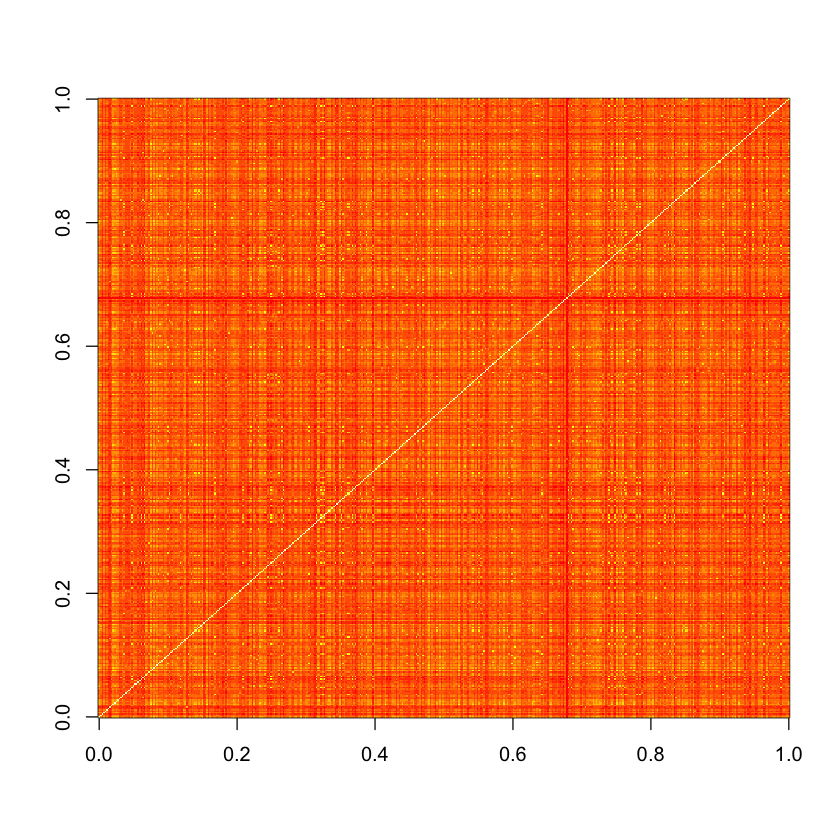

In [11]:
# Let us see what the matrix looks like
Sigma <- cov(detrended.returns)
image(Sigma)

# A quick sanity check

As a sanity check, let's compute the SVD of Sigma and see how the first few PCs relate to the industry of the stocks.

In [14]:
s1 <- eigen(Sigma)$vectors[,1]
s2 <- eigen(Sigma)$vectors[,2]
s3 <- eigen(Sigma)$vectors[,3]
s4 <- eigen(Sigma)$vectors[,4]


# Recover the Sector of each stock
industries <- c()
for (nm in sapply(strsplit(colnames(Sigma), '.', fixed=T), FUN=function(x){x[[1]][1]})) {
    if (nm == 'BRK') {
        nm <- 'BRK-B'
    }
    if (nm == 'BF') {
        nm <- 'BF-B'
    }
    industries <- c(industries, symbols_table$`GICS Sector`[which(symbols_table$Symbol == nm)])
}

D2 <- cbind(s1, s2, s3, s4, industries)
D2 <- as.data.frame(D2)
D2[,1] <- as.numeric(as.character(D2[,1]))
D2[,2] <- as.numeric(as.character(D2[,2]))
D2[,3] <- as.numeric(as.character(D2[,3]))
D2[,4] <- as.numeric(as.character(D2[,4]))
colnames(D2) <- c("V1", "V2", "V3", "V4", "Industry")

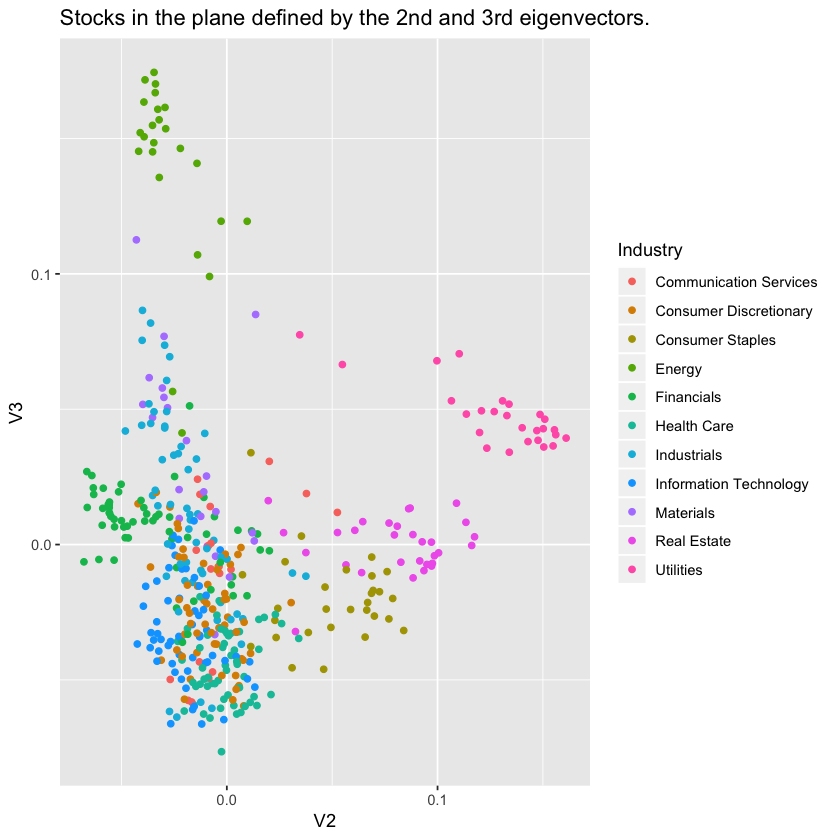

In [16]:
ggplot(D2, aes(x=V2, y=V3)) + geom_point(aes(colour=Industry)) + ggtitle("Stocks in the plane defined by the 2nd and 3rd eigenvectors.")

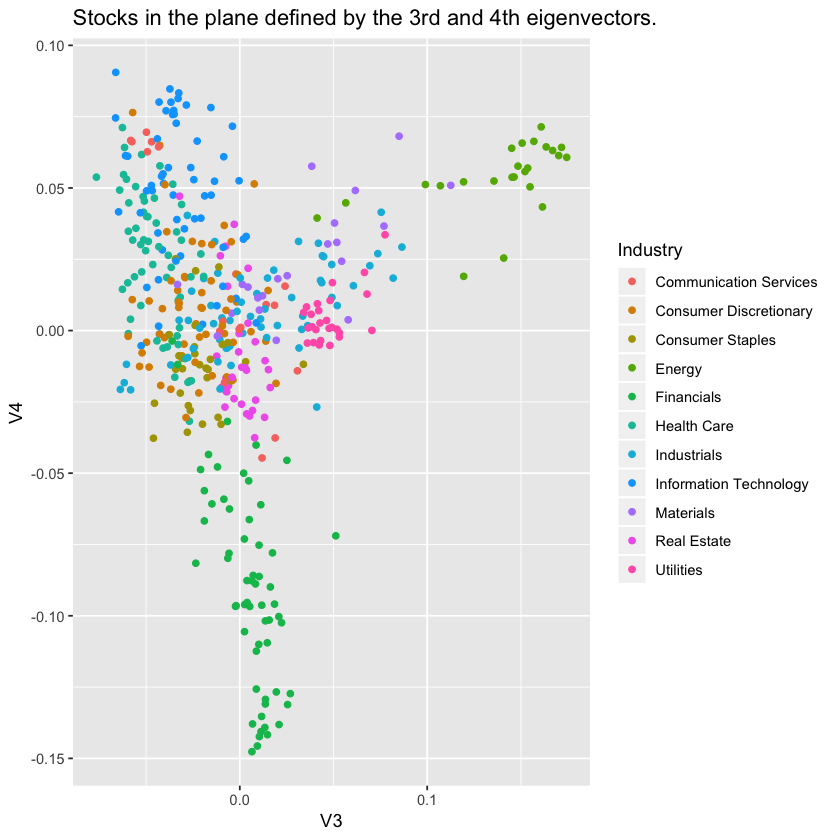

In [17]:
ggplot(D2, aes(x=V3, y=V4)) + geom_point(aes(colour=Industry)) + ggtitle("Stocks in the plane defined by the 3rd and 4th eigenvectors.")

The final dataset has dimensions:

In [21]:
dim(detrended.returns)

[1] 2556  442

In [18]:
# Save this for other tutorials
save(detrended.returns, symbols_table, industries, file="data/sp500_data.RData")